In [98]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix


In [99]:
# 데이터 불러오기 및 중복제거
labeled_data  = pd.read_csv('labeled.csv')
unlabeled_data = pd.read_csv('unlabeled.csv')
labeled_data['PassOrFail'] = labeled_data['PassOrFail'].replace('Y', 0).replace('N', 1)
labeled_data.drop_duplicates(inplace=True)


In [100]:
# unlabeled data features 확인
unlabeled_data.columns


Index(['Unnamed: 0', '_id', 'TimeStamp', 'PART_FACT_PLAN_DATE',
       'PART_FACT_SERIAL', 'PART_NO', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME',
       'ERR_FACT_QTY', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Switch_Over_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7',
       'Hopper_Temperature', 'Mold_Temperature_1', 'Mold_Temperature_2',
       'Mold_Temperature_3', 'Mold_Temperature_4', 'Mold_Temperature_5',
       'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
       'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_

In [101]:
# labeled data features 확인
labeled_data.columns


Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
       'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'PassOrFail', 'Reason',
       'Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Switch_Over_Position',
       'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed',
       'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Barrel_Temperature_7', 'Hopper_Temperature',
       'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_3',
       'Mold_Temperature_4', 'Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11', 

In [102]:
def make_input(data, machine_name, product_name):
    machine_ = data['EQUIP_NAME'] == machine_name
    product_ = data['PART_NAME']  == product_name
    data = data[machine_ & product_]
    data.drop(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'Mold_Temperature_1','Mold_Temperature_2','Mold_Temperature_5','Mold_Temperature_6','Mold_Temperature_7','Mold_Temperature_8','Mold_Temperature_9','Mold_Temperature_10','Mold_Temperature_11','Mold_Temperature_12'], axis=1, inplace=True)
    return data

In [103]:
# unlabeled에서 우진2호기만 뽑아내고 cn7, rg3, cn7+rg3 데이터구분
machine_name = '650톤-우진2호기'
product_name = ["CN7 W/S SIDE MLD'G LH", "CN7 W/S SIDE MLD'G RH", "RG3 MOLD'G W/SHLD, RH", "RG3 MOLD'G W/SHLD, LH"]
cn7lh = make_input(unlabeled_data, machine_name, product_name[0])
cn7rh = make_input(unlabeled_data, machine_name, product_name[1])

rg3lh = make_input(unlabeled_data, machine_name, product_name[2])
rg3rh = make_input(unlabeled_data, machine_name, product_name[3])

cn7_train = pd.concat([cn7lh, cn7rh], ignore_index=True) # unlabeled에서 cn7만 추출
rg3_train = pd.concat([rg3lh, rg3rh], ignore_index=True) # unlabeled에서 rg3만 추출
cn_rg_train = pd.concat([cn7lh, cn7rh, rg3lh, rg3rh], ignore_index=True) # unlabeled에 cn7 + rg3

# 각각 필요없는 col 제거
cn7_train.drop(['Unnamed: 0', 'Switch_Over_Position', 'Barrel_Temperature_7', 'PART_NO', 'ERR_FACT_QTY'], axis=1, inplace=True)
rg3_train.drop(['Unnamed: 0', 'Plasticizing_Position', 'PART_NO', 'ERR_FACT_QTY'], axis=1, inplace=True)
cn_rg_train.drop(['Unnamed: 0', 'PART_NO', 'ERR_FACT_QTY'], axis=1, inplace=True)



C:\Users\jeonj\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [104]:
for column in cn_rg_train.columns:
  if cn_rg_train['Injection_Time'][cn_rg_train[column]==0].count() == len(cn_rg_train):
    print(column)   

In [105]:
# 트레이닝셋 shape 확인
print("CN7+RG3: ", cn_rg_train.shape)
print("CN7: ", cn7_train.shape)
print("RG3: ", rg3_train.shape)

CN7+RG3:  (71180, 26)
CN7:  (35239, 24)
RG3:  (35941, 25)


In [106]:
# 테스트 데이터셋 구성
# labeled 에서 cn7, rg3, cn7+rg3 데이터 구분
product_name = ["CN7 W/S SIDE MLD'G LH", "CN7 W/S SIDE MLD'G RH", "RG3 MOLD'G W/SHLD, RH", "RG3 MOLD'G W/SHLD, LH"]
cn7lh = make_input(labeled_data, machine_name, product_name[0])
cn7rh = make_input(labeled_data, machine_name, product_name[1])

rg3lh = make_input(labeled_data, machine_name, product_name[2])
rg3rh = make_input(labeled_data, machine_name, product_name[3])

cn7_test = pd.concat([cn7lh, cn7rh], ignore_index=True) # cn7
rg3_test = pd.concat([rg3lh, rg3rh], ignore_index=True) # rg3
cn_rg_test = pd.concat([cn7lh, cn7rh, rg3lh, rg3rh], ignore_index=True) # cn7 + rg3


In [107]:
#각 테스트셋 양품 불량품 갯수확인 
cn_pdf = cn7_test.loc[cn7_test['PassOrFail'] == 0].copy()
cn_ndf = cn7_test.loc[cn7_test['PassOrFail'] == 1].copy()

rg_pdf = rg3_test.loc[rg3_test['PassOrFail'] == 0].copy()
rg_ndf = rg3_test.loc[rg3_test['PassOrFail'] == 1].copy()

cn_rg_pdf = cn_rg_test.loc[cn_rg_test['PassOrFail'] == 0].copy()
cn_rg_ndf = cn_rg_test.loc[cn_rg_test['PassOrFail'] == 1].copy()

print("CN7 양품: ", cn_pdf.shape, "CN7 불량품:" , cn_ndf.shape)
print("RG3 양품: ", rg_pdf.shape, "RG3 불량품:" , rg_ndf.shape)
print("CN+RG 양품: ", cn_rg_pdf.shape, "CN+RG 불량품:" , cn_rg_ndf.shape)

CN7 양품:  (3946, 28) CN7 불량품: (28, 28)
RG3 양품:  (1224, 28) RG3 불량품: (32, 28)
CN+RG 양품:  (5170, 28) CN+RG 불량품: (60, 28)


In [108]:
# 테스트셋 feature 제거
cn_pdf.drop(['PassOrFail', 'Reason', 'Switch_Over_Position', 'Barrel_Temperature_7'], axis=1, inplace=True) #col = 24
cn_ndf.drop(['PassOrFail', 'Reason', 'Switch_Over_Position', 'Barrel_Temperature_7'], axis=1, inplace=True) #col = 24

rg_pdf.drop(['PassOrFail', 'Reason', 'Plasticizing_Position'], axis=1, inplace=True) #col = 25
rg_ndf.drop(['PassOrFail', 'Reason', 'Plasticizing_Position'], axis=1, inplace=True) #col = 25

cn_rg_pdf.drop(['PassOrFail', 'Reason'], axis=1, inplace=True) #col = 26
cn_rg_ndf.drop(['PassOrFail', 'Reason'], axis=1, inplace=True) #col = 26




In [109]:
# shape 확인
print("######### 테스트셋 ###########")
print("CN7 양품: ", cn_pdf.shape, "CN7 불량품:" , cn_ndf.shape)
print("RG3 양품: ", rg_pdf.shape, "RG3 불량품:" , rg_ndf.shape)
print("CN+RG 양품: ", cn_rg_pdf.shape, "CN+RG 불량품:" , cn_rg_ndf.shape)
print("\n######### 트레이닝셋 ###########")
print("CN7: ", cn7_train.shape)
print("RG3: ", rg3_train.shape)
print("CN7+RG3: ", cn_rg_train.shape)


######### 테스트셋 ###########
CN7 양품:  (3946, 24) CN7 불량품: (28, 24)
RG3 양품:  (1224, 25) RG3 불량품: (32, 25)
CN+RG 양품:  (5170, 26) CN+RG 불량품: (60, 26)

######### 트레이닝셋 ###########
CN7:  (35239, 24)
RG3:  (35941, 25)
CN7+RG3:  (71180, 26)


In [110]:
# 데이터셋 정규화
scaler = MinMaxScaler()
cn7_X = scaler.fit_transform(cn7_train) # 언라벨데이터
cn7_Y = scaler.transform(cn_pdf) # 라벨
cn7_N = scaler.fit_transform(cn_ndf) # 라벨

rg3_X = scaler.fit_transform(rg3_train) # 언라벨
rg3_Y = scaler.transform(rg_pdf) # 라벨
rg3_N = scaler.fit_transform(rg_ndf) # 라벨

cnrg_X = scaler.fit_transform(cn_rg_train) # 언라벨
cnrg_Y = scaler.transform(cn_rg_pdf) # 라벨
cnrg_N = scaler.transform(cn_rg_ndf) # 라벨

# sol2) CN7 정규화를 먼저 해버리고 트레이닝 테스트셋 나누기
# cn7_df = pd.concat([cn7_train, cn_pdf, cn_ndf], ignore_index=True)
# norm_cn7 = scaler.fit_transform(cn7_df)
# cn7_X = norm_cn7[:35239]
# cn7_Y = norm_cn7[35239:39185]
# cn7_N = norm_cn7[39185:]



In [111]:
# 모델링
dropout_encoder = Sequential([
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dense(5, activation='relu')
])

dropout_decoder = Sequential([
    Dense(15, activation='relu', input_shape=[5]),
    Dense(cn7_X.shape[1], activation='relu')
])

dropout_AE = Sequential([dropout_encoder, dropout_decoder])

In [112]:
dropout_AE.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['accuracy'])
history = dropout_AE.fit(cn7_X, cn7_X, batch_size=30, epochs=100, validation_split=0.2)
callbacks = [EarlyStopping(monitor='val_loss', patience=7, mode='min')]

Epoch 1/100
940/940 [==============================] - 1s 903us/step - loss: 0.0865 - accuracy: 0.3479 - val_loss: 0.0844 - val_accuracy: 0.9729
Epoch 2/100
940/940 [==============================] - 1s 922us/step - loss: 0.0828 - accuracy: 0.3568 - val_loss: 0.0823 - val_accuracy: 0.9729
Epoch 3/100
940/940 [==============================] - 1s 978us/step - loss: 0.0824 - accuracy: 0.3588 - val_loss: 0.0818 - val_accuracy: 0.9729
Epoch 4/100
940/940 [==============================] - 1s 985us/step - loss: 0.0822 - accuracy: 0.3644 - val_loss: 0.0819 - val_accuracy: 0.9729
Epoch 5/100
940/940 [==============================] - 1s 967us/step - loss: 0.0821 - accuracy: 0.3616 - val_loss: 0.0817 - val_accuracy: 0.3253
Epoch 6/100
940/940 [==============================] - 1s 968us/step - loss: 0.0820 - accuracy: 0.3654 - val_loss: 0.0815 - val_accuracy: 0.9729
Epoch 7/100
940/940 [==============================] - 1s 921us/step - loss: 0.0818 - accuracy: 0.3514 - val_loss: 0.0816 - val_ac

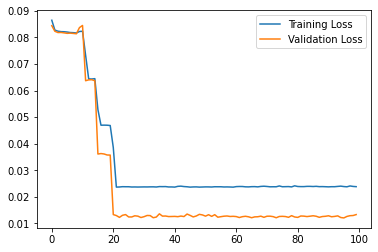

In [113]:
# dropout_AE.save('saved_model.pb')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

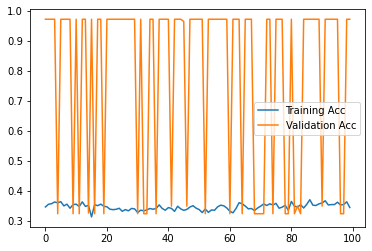

In [114]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.legend()
plt.show()    

In [115]:
cn7_train_pred = dropout_AE.predict(cn7_Y)
cn7_train_loss = np.mean(np.square(cn7_train_pred - cn7_Y), axis=1)

threshold = np.mean(cn7_train_loss) + 5 * np.std(cn7_train_loss)

print("복원 오류 임계치: ", threshold)

복원 오류 임계치:  0.09380687052688988


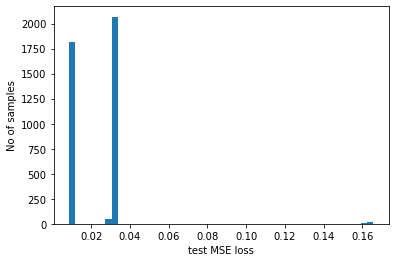

  불량 개수:  18


In [116]:
cn7_predict_Y = dropout_AE.predict(cn7_Y)
cn7_test_Y_mse = np.mean(np.square(cn7_predict_Y - cn7_Y), axis=1)

plt.hist(cn7_test_Y_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

cn7_test_Y_anomalies = cn7_test_Y_mse > threshold
print("  불량 개수: ", np.sum(cn7_test_Y_anomalies))

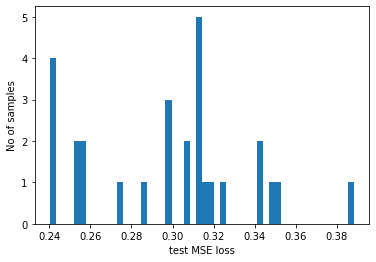

  불량 개수:  28


In [117]:
cn7_predict_N = dropout_AE.predict(cn7_N)
cn7_test_N_mse = np.mean(np.square(cn7_predict_N - cn7_N), axis=1)

plt.hist(cn7_test_N_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

cn7_test_N_anomalies = cn7_test_N_mse > threshold
print("  불량 개수: ", np.sum(cn7_test_N_anomalies))

In [118]:
cn7_true = np.concatenate([np.zeros(len(cn7_test_Y_anomalies)), np.ones(len(cn7_test_N_anomalies))])

In [119]:
cn7_prediction = np.concatenate([cn7_test_Y_anomalies, cn7_test_N_anomalies])

In [120]:
from sklearn.metrics import confusion_matrix
confusion_matrix(cn7_prediction, cn7_true)

array([[3928,    0],
       [  18,   28]], dtype=int64)

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("정확도: ", accuracy_score(cn7_true, cn7_prediction))
print("정밀도: ", precision_score(cn7_true, cn7_prediction))
print("재현율: ", recall_score(cn7_true, cn7_prediction))
print("F1: ", f1_score(cn7_true, cn7_prediction))

정확도:  0.9954705586311021
정밀도:  0.6086956521739131
재현율:  1.0
F1:  0.7567567567567568


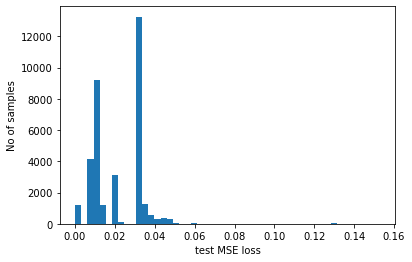

불량 개수:  66


In [122]:
# unlabeled 데이터 predict
cn7_predict_Y = dropout_AE.predict(cn7_X)
cn7_test_Y_mse = np.mean(np.square(cn7_predict_Y - cn7_X), axis=1)

plt.hist(cn7_test_Y_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

cn7_test_Y_anomalies = cn7_test_Y_mse > threshold
print("불량 개수: ", np.sum(cn7_test_Y_anomalies))